MJO packages  
https://mdtf-diagnostics.readthedocs.io/en/latest/sphinx_pods/MJO_suite.html  
https://github.com/NOAA-GFDL/MDTF-diagnostics/tree/main/diagnostics/MJO_prop_amp

## Load pre-computed data?

In [1]:
LOAD = True
data_dir = '/vortexfs1/scratch/kcarr/era-interim'

In [2]:
# import os
from os.path import join
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
import os
from multiprocessing import Pool
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from collections import Counter
import cartopy.crs as ccrs
from copy import deepcopy

# Add directory to path
import sys
sys.path.append('/vortexfs1/home/kcarr/summer-project-2020/') 
import utils
from utils import stack_month_and_year, unstack_month_and_year, get_proj_xr
from preprocess import remove_season, get_trend_fast

# Function to detrend
def prep(x):
    '''Function removes trend and seasonal cycle from xarray variable'''
    y = x - get_trend_fast(x)
    y = y.groupby('time.month') - y.groupby('time.month').mean()
    return y

def prep_mjo_data(x):
    '''Function to pre-process data associated with the MJO
    Specifically: 1. remove linear relationship with ENSO
                  2. remove 120 day running mean
                  3. average over latitudes, and normalize by global variance'''
    print( 'Removing linear relationship with ENSO...')
    x_mjo = x - get_proj_xr(oni_daily, x) # remove relationship with ENSO
    print('Removing 120-day running mean...')
    x_mjo = x_mjo.isel(time=slice(119,None)) - \
        x_mjo.rolling(time=120).mean().isel(time=slice(119,None)) # 120-day mean
    x_mjo = x_mjo.mean(dim='latitude')
    x_mjo = x_mjo / x_mjo.std()
    return x_mjo

def get_mjo_phase(x, y):
    '''Function to get the phase of the MJO, based on first two PCs from Wheeler/Hendon index'''
    mag = np.sqrt(x**2 + y**2)
    if mag < 1: # only classify if magnitude is greater than 1
        return -1
    else:
        if x>=0:
            if y>=0:
                return 5. if np.abs(x)>=np.abs(y) else 6
            else:
                return 4 if np.abs(x)>=np.abs(y) else 3
        else:
            if y>=0:
                return 8 if np.abs(x)>=np.abs(y) else 7
            else:
                return 1 if np.abs(x)>=np.abs(y) else 2
            return
        return
    return

def get_mjo_phase_(data):
    '''Helper function: takes single argument, allowing us to pass it to np.apply_along_axis'''
    x,y = data
    return get_mjo_phase(x,y)

cdo


# Pre-process data (or load pre-computed data)

In [3]:
if LOAD:
    print('Loading pre-computed data')
    ##### Read in de-trended and de-seasonalized data
    oni = xr.open_dataarray(os.path.join(data_dir, 'oni.nc'))
    oni_daily = xr.open_dataarray(os.path.join(data_dir, 'oni_daily.nc'))
    olr = xr.open_dataarray(os.path.join(data_dir, 'olr_prep.nc'))
    u = xr.open_dataarray(os.path.join(data_dir, 'u_prep.nc'))
    v = xr.open_dataarray(os.path.join(data_dir, 'v_prep.nc'))
    tp = xr.open_dataarray(os.path.join(data_dir, 'tp_prep.nc'))
    tp_us = xr.open_dataarray(os.path.join(data_dir, 'tp_us_prep.nc'))
    mjo_data = xr.open_dataarray(os.path.join(data_dir, 'mjo_data.nc'))

else:
    print('Pre-processing data')
    # read in raw data
    sst = xr.open_dataset(join(data_dir, 'sst.mon.mean.nc')).sst
    olr = xr.open_dataset(join(data_dir, 'ttr_daily.nc')).ttr
    olr = olr / (12*3600) # convert units from J/m^2 to W/m^2 -> divide by number of seconds in 12 hours
    u = xr.open_dataset(join(data_dir, 'u_daily.nc')).u
    v = xr.open_dataset(join(data_dir, 'v_daily.nc')).v
    tp = xr.open_dataset(join(data_dir, 'tp_daily.nc')).tp
    tp_us = xr.open_dataset(join(data_dir, 'tp_us_daily.nc')).tp
    tp_us = tp_us * 1000*2*30 # convert from m/[12-hr] to mm/month

    # compute ONI anomalies (ENSO index)
    sst = sst - get_trend_fast(sst)
    sst = remove_season(sst, standardize=False)[0]
    oni = sst.mean(dim=['longitude','latitude']).rolling(time=3).mean()
    # interpolate to daily
    oni_daily = oni.interp(time=pd.date_range('1979-01-01', '2017-12-02', freq='D'))
    
    # MAKE SURE TIMES MATCH
    oni_daily = oni_daily.isel(time=slice(None,-1)) # Get rid of extra time step
    olr = olr.isel(time=slice(None,-1))
    tp = tp.isel(time=slice(None,-1))
    tp_us = tp_us.isel(time=slice(None,-1))
    olr['time'] = oni_daily.time # set times equal
    tp['time'] = oni_daily.time
    u['time'] = oni_daily.time
    v['time'] = oni_daily.time
    tp_us['time'] = oni_daily.time
    oni_daily = oni_daily.isel(time=slice(60,None)) # Remove first 60 time steps
    u = u.isel(time=slice(60,None))
    v = v.isel(time=slice(60,None))
    tp = tp.isel(time=slice(60,None))
    olr = olr.isel(time=slice(60,None))
    tp = tp.isel(time=slice(60,None))
    tp_us = tp_us.isel(time=slice(60,None))
    
    # remove trend and seasonal cycle from atmospheric data
    res = []
    for d in[olr, u, v, tp, tp_us]:
        res.append(prep(d))

    # unpack results    
    olr, u, v, tp, tp_us = res
    
    # prep MJO data (i.e. remove ENSO, average over latitudes, divide by global var)
    u200_mjo = prep_mjo_data(u.sel(level=200).drop('level'))
    u850_mjo = prep_mjo_data(u.sel(level=850).drop('level'))
    olr_mjo = prep_mjo_data(olr)
    mjo_data = xr.concat([u200_mjo, u850_mjo, olr_mjo],
                         dim=pd.Index(['u200','u850','olr'], name='variable'))
    mjo_data = mjo_data.transpose('time',...)
    mjo_data = mjo_data - mjo_data.mean (dim='time') # make sure data is centered at 0

    ##### SAVE RESULTS
    oni.to_netcdf(os.path.join(data_dir, 'oni.nc'))
    oni_daily.to_netcdf(os.path.join(data_dir, 'oni_daily.nc'))
    olr.to_netcdf(os.path.join(data_dir, 'olr_prep.nc'))
    u.to_netcdf(os.path.join(data_dir, 'u_prep.nc'))
    v.to_netcdf(os.path.join(data_dir, 'v_prep.nc'))
    tp.to_netcdf(os.path.join(data_dir, 'tp_prep.nc'))
    tp_us.to_netcdf(os.path.join(data_dir, 'tp_us_prep.nc'))
    mjo_data.to_netcdf(os.path.join(data_dir, 'mjo_data.nc'))
    
# mask precipitation data
lsm = xr.open_dataset(join(data_dir, 'invariants.nc')).lsm.squeeze('time', drop='True')
lsm =lsm.interp(latitude=tp_us.latitude, longitude=tp_us.longitude)
cutoff=.3
lsm.values[lsm < cutoff] = 0.
lsm.values[lsm >= cutoff] = 1.
tp_us = tp_us * lsm

Loading pre-computed data


# EOFs

In [4]:
eof_obj = Eof(mjo_data) #### EOF analysis to get MJO index

# Get 1st two principal components (used to identify MJO phase)
rmm = eof_obj.pcs(pcscaling=1, npcs=2)
rmm1 = rmm.sel(mode=0)
rmm2 = rmm.sel(mode=1)

# check reconstruction
res2 = np.einsum('ab,bcd->acd', eof_obj.pcs(pcscaling=1), eof_obj.eofs(eofscaling=2)).reshape(mjo_data.shape)
print(np.allclose(mjo_data, res2))

##### Determine MJO phases ######
mjo_phase = np.nan * deepcopy(rmm1)
mjo_phase.values = np.apply_along_axis(func1d=get_mjo_phase_, 
                                       arr=np.stack([rmm1.values,rmm2.values],axis=1), 
                                       axis=1)

True


# Plots

### Leading EOFs and explained variance

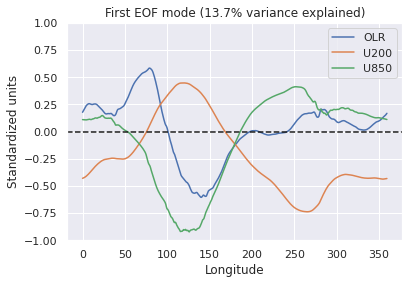

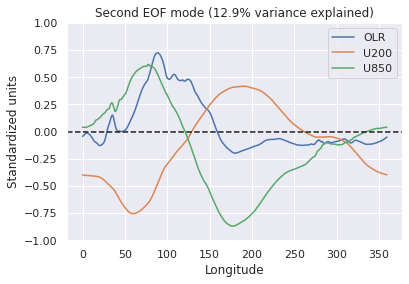

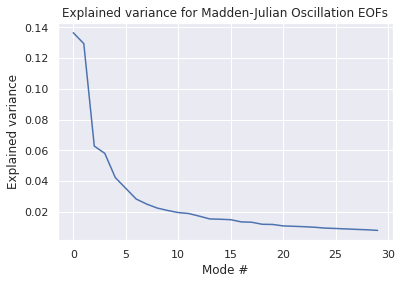

In [5]:
####### Plot the two dominant EOFs (corresponding to the RMM index)
s=2 # scaling to use for EOF plots

# First EOF
fig,ax=plt.subplots()
ax.plot(eof_obj.eofs().longitude, eof_obj.eofs(eofscaling=s).sel(mode=0, variable='olr'), label='OLR')
ax.plot(eof_obj.eofs().longitude, eof_obj.eofs(eofscaling=s).sel(mode=0, variable='u200'), label='U200')
ax.plot(eof_obj.eofs().longitude, eof_obj.eofs(eofscaling=s).sel(mode=0, variable='u850'), label='U850')
ax.axhline(y=0, linestyle='--',color='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Standardized units')
ax.set_ylim([-1,1])
v1 = eof_obj.varianceFraction(neigs=1).values.item()
ax.set_title(f'First EOF mode ({100*v1:.1f}% variance explained)')
ax.legend()
plt.show()

# Second EOF
fig,ax=plt.subplots()
ax.plot(eof_obj.eofs().longitude, eof_obj.eofs(eofscaling=s).sel(mode=1, variable='olr'), label='OLR')
ax.plot(eof_obj.eofs().longitude, eof_obj.eofs(eofscaling=s).sel(mode=1, variable='u200'), label='U200')
ax.plot(eof_obj.eofs().longitude, eof_obj.eofs(eofscaling=s).sel(mode=1, variable='u850'), label='U850')
ax.axhline(y=0, linestyle='--',color='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Standardized units')
ax.set_ylim([-1,1])
v2 = eof_obj.varianceFraction(neigs=2).values[-1].item()
ax.set_title(f'Second EOF mode ({100*v2:.1f}% variance explained)')
ax.legend()
plt.show()

# Explained variance for EOFs
fig,ax=plt.subplots()
ax.plot(eof_obj.varianceFraction(neigs=30))
ax.set_ylabel('Explained variance')
ax.set_xlabel('Mode #')
ax.set_title('Explained variance for Madden-Julian Oscillation EOFs')
plt.show()

## MJO phase composites

#### OLR/U850 composite

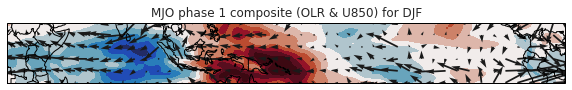

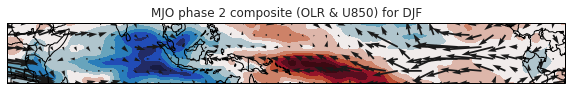

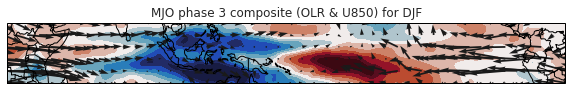

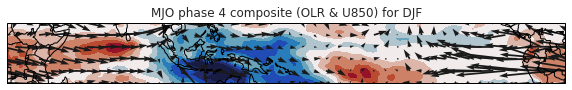

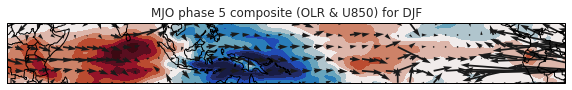

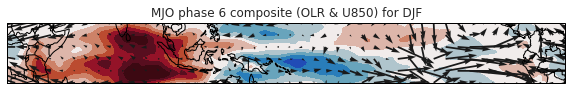

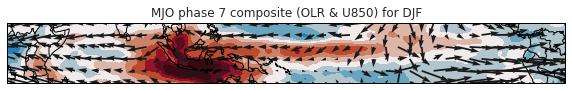

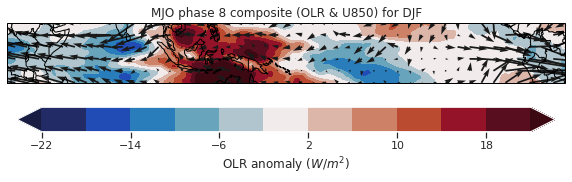

In [6]:
DJF = True # only plot composite for DJF months?

n=8 # plot every nth vector in the plots
for phase in np.arange(1,9): # do for each of the 8 phases
    d = mjo_phase[mjo_phase==phase].time
    if DJF: # get DJF months
        d = d[(d.dt.month == 12) | (d.dt.month == 1) | (d.dt.month == 2)] 
    phase_composite = olr.sel(time=d).mean(dim='time') # get OLR composite
    u_composite = u.sel(time=d, level=850).mean(dim='time')
    v_composite = v.sel(time=d, level=850).mean(dim='time')
    
    fig, ax = utils.plot_setup(plot_range=[20,300,-15,15],
                               central_lon=180,figsize=(10,3))
    ax.set_title(f'MJO phase {phase} composite (OLR & U850) for DJF')
    cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
                     phase_composite, cmap='cmo.balance', extend='both', 
                     transform=ccrs.PlateCarree(), levels=np.arange(-22,26,4))
#                     levels=np.array([-30,-22.5,-15,-7.5,7.5,15,22.5,30]))
    qv = ax.quiver(u.longitude.values[::n], # plot wind
                   u.latitude.values[::n],
                   u_composite[::n,::n],
                   v_composite[::n,::n])
    if phase==8:
        cb = fig.colorbar(cp, orientation='horizontal', label=r'OLR anomaly ($W/m^2$)')
    plt.show()

### plot sample of MJO phase

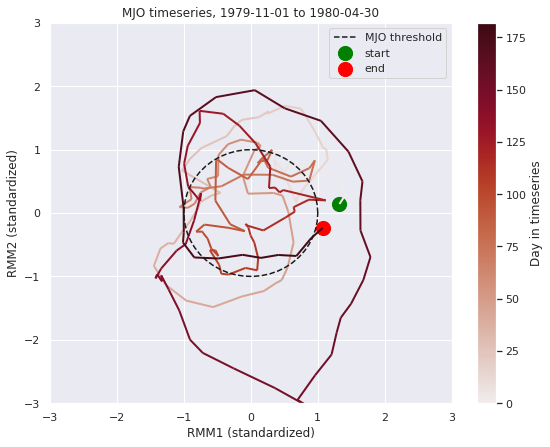

In [7]:
theta = np.linspace(0,2*np.pi)
x0 = np.cos(theta)
y0 = np.sin(theta)
year = 1979
d1 = f'{year}-11-01'
d2 = f'{year+1}-04-30'
x = rmm1.sel(time=slice(d1,d2))
y = rmm2.sel(time=slice(d1,d2))

fig,ax = plt.subplots(figsize=(9,7))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, len(x))
lc = LineCollection(segments, cmap='cmo.amp', norm=norm)
lc.set_array(np.arange(len(x)))
lc.set_linewidth(2)
line = ax.add_collection(lc)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.scatter(x[0],y[0],marker='o', s=200, label='start', color='green')
ax.scatter(x[-1],y[-1],marker='o', s=200, label='end', color='red')
ax.plot(x0,y0, linestyle='--', color='k', label='MJO threshold')
ax.set_xlabel('RMM1 (standardized)')
ax.set_ylabel('RMM2 (standardized)')
ax.set_title('MJO timeseries, 1979-11-01 to 1980-04-30')
ax.legend()
fig.colorbar(line, label='Day in timeseries')
plt.show()

### Distribution of MJO over months

In [8]:
phase_counts   = Counter(mjo_phase[mjo_phase>0].values)
monthly_counts = Counter(mjo_phase[mjo_phase>0].time.dt.month.values)

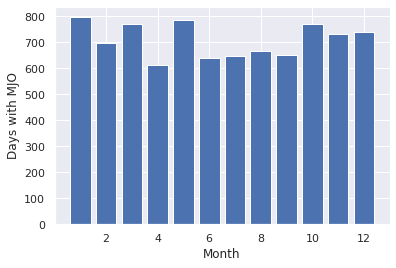

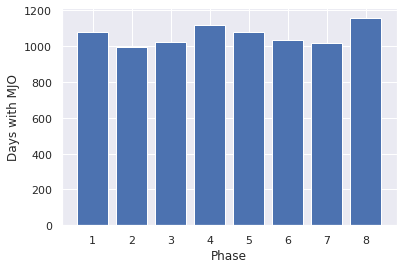

In [9]:
fig,ax = plt.subplots()
ax.bar(monthly_counts.keys(), monthly_counts.values())
ax.set_xlabel('Month')
ax.set_ylabel('Days with MJO')
plt.show()

fig,ax = plt.subplots()
ax.bar(phase_counts.keys(), phase_counts.values())
ax.set_xlabel('Phase')
ax.set_ylabel('Days with MJO')
plt.show()

### MJO composite for precipitation

Use significance testing!!!!!!!!  
estimate mean and standard error for the estimate (std dev divided by M^2)  
how to create standardized plots (divide by standard error? or standard deviation?)  
compare to 0 (using standard hypothesis test and monte carlo)  

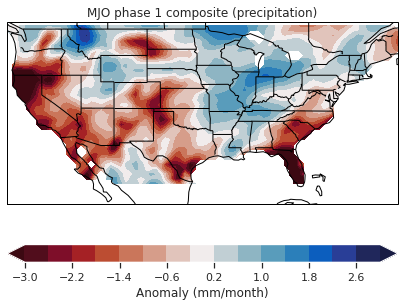

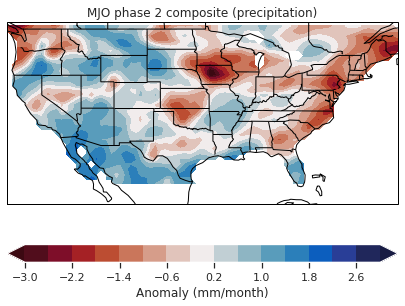

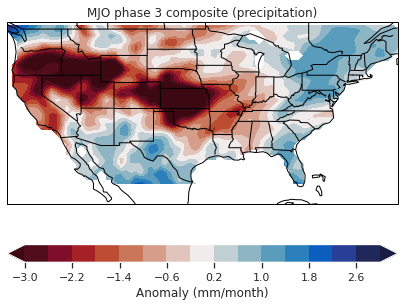

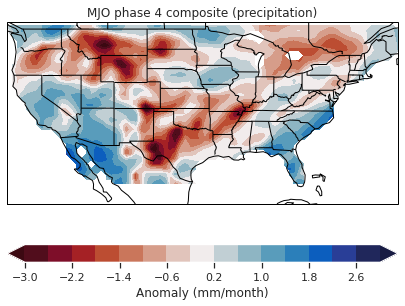

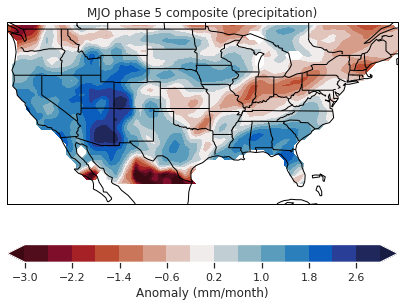

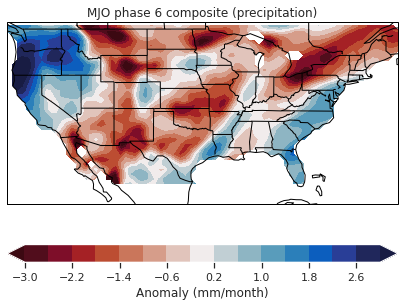

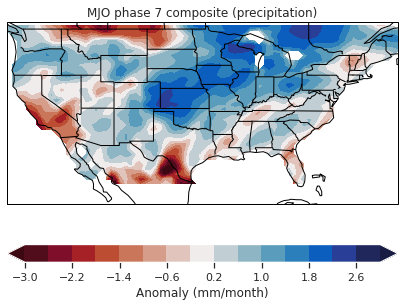

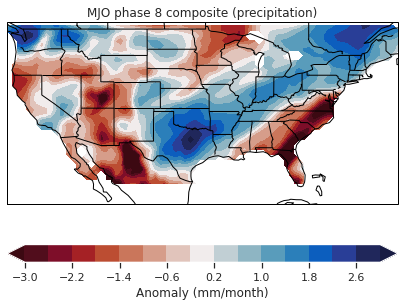

In [78]:
for phase in range(1,9):
    d = mjo_phase[mjo_phase==phase].time
    d = d[(d.dt.month == 12) | (d.dt.month == 1) | (d.dt.month == 2)]
    M = len(d.time)
    phase_composite = tp_us.sel(time=d).mean(dim='time')
    phase_composite_stderr = tp_us.sel(time=d).std(dim='time') / np.sqrt(M)
    
#     fig,ax = utils.plot_setup()
#     cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
#                      phase_composite, cmap='cmo.balance_r',
#                     levels=np.linspace(-24,24,12), extend='both')
#     if phase==8:
#         cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
#     ax.set_title(f'MJO phase {phase} composite (precipitation)')
#     plt.show()
    
#     fig,ax = utils.plot_setup()
#     cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
#                      phase_composite_std, cmap='cmo.amp',
#                     levels=10, extend='both')
#     cb = fig.colorbar(cp, orientation='horizontal', label='variance')
#     ax.set_title(f'MJO phase {phase} variance')
#     plt.show()
    fig,ax = utils.plot_setup()
    cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
                     phase_composite/phase_composite_stderr, cmap='cmo.balance_r',
                    levels=np.arange(-3.0,3.4,.4), extend='both')
    cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
    ax.set_title(f'MJO phase {phase} composite (precipitation)')
    plt.show()

# Precipitation clustering / ENSO analysis

### Identify precipitation regions

In [9]:
print('clustering')
prect_ = prect.stack(posn=['lat','lon'])

idx = np.where(~np.isnan(prect_.isel(time=0)).values)[0]
vals = prect_.isel(posn=idx).values

from sklearn.cluster import KMeans
from copy import deepcopy

# Fit kmeans
model = KMeans(n_clusters=9)
model.fit(vals.T)

# Get labels
labels = np.nan*deepcopy(prect_.isel(time=0, drop=True))
labels[idx] = model.labels_
labels = labels.unstack()

k_vals = np.unique(labels.values)
k_vals = k_vals[~np.isnan(k_vals)]

cluster_mask = xr.concat([labels for _ in range(len(k_vals))], dim='cluster').assign_coords({'cluster':k_vals})
for i,c in enumerate(cluster_mask.cluster.values):
    cluster_mask.values[i,:] = 1. * cluster_mask.values[i,:]==c

cluster_mask.values[cluster_mask.values==0] = np.nan    

clustering


**Plot clusters**

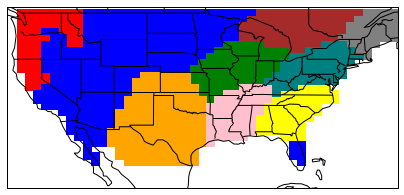

In [10]:
def plot_clusters(labels, colors, plot_range=[-125.25, -66, 22.5, 50]):
    '''Function plots clusters on map'''
    x,y = np.meshgrid(labels.lon.values, labels.lat.values)
    k_vals = np.unique(labels.values)
    k_vals = k_vals[~np.isnan(k_vals)]
    fig, ax = utils.plot_setup()
    for i, k in enumerate(k_vals):
        color = ListedColormap(colors[i])
        mask = (labels.values==k)*1.
        mask[mask==0] = np.nan
        ax.pcolormesh(x,y,mask, cmap=color)
    return fig, ax

colors = ['red','blue','green','orange','pink','yellow', 'brown', 'gray', 'teal']
fig, ax = plot_clusters(labels, colors = colors)

## Composite of El-Nino events

In [8]:
nino_days = oni_daily[oni_daily > oni_daily.std()].time
nina_days = oni_daily[oni_daily < -oni_daily.std()].time

In [9]:
nino_composite = prect.sel(time=nino_days).mean(dim='time')
nina_composite = prect.sel(time=nina_days).mean(dim='time')

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


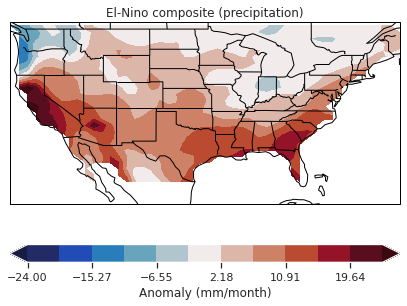

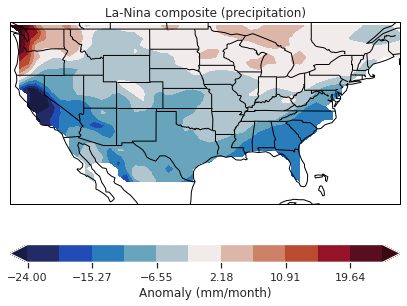

In [10]:
a = 1000*3600*24*365/12 # conversion factor from m/s to mm/month

fig,ax = utils.plot_setup()
cp = ax.contourf(nino_composite.lon, nino_composite.lat, a*nino_composite, cmap='cmo.balance',
                levels=np.linspace(-24,24,12), extend='both')
cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
ax.set_title(r'El-Nino composite (precipitation)')
plt.show()

fig,ax = utils.plot_setup()
cp = ax.contourf(nina_composite.lon, nina_composite.lat, a*nina_composite, cmap='cmo.balance',
                levels=np.linspace(-24,24,12), extend='both')
cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
ax.set_title(r'La-Nina composite (precipitation)')
plt.show()

#### ONI timeseries

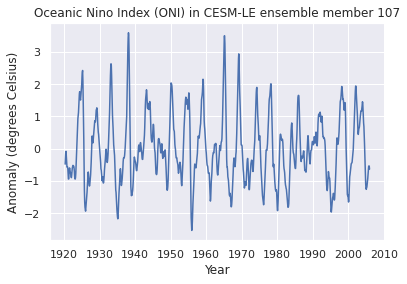

In [5]:
## plot ONI index
fig,ax = plt.subplots()
ax.plot(oni.time, oni)
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly (degrees Celsius)')
ax.set_title('Oceanic Nino Index (ONI) in CESM-LE ensemble member 107')
plt.show()

# Analysis
- power spectrum (ENSO RMM components, and precip)
- linear regression
- neural net
- stochastic model (?)

#### RMM lagged correlation

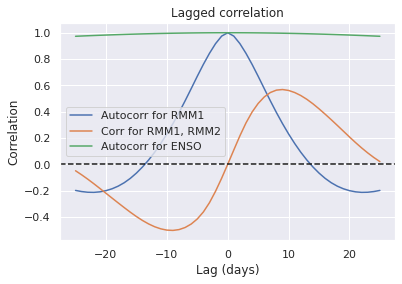

Correlation with ENSO
RMM1: 0.022
RMM2: 0.109


In [11]:
def get_rho(x1, x2):
    '''Function to get correlation coefficient for 2 timeseries'''
    x = np.stack([x1,x2], axis=1)
    cov = (x.T @ x) / (len(x)-1)
    rho = cov[0,1] / np.prod(np.sqrt(np.diag(cov)))
    return rho
def get_lagged_autocorr(x, lags=np.arange(1,26)):
    '''Get lagged autocorrelation for time series, and reflect about t=0'''
    rho = []
    for lag in lags:
        x1 = x[:-lag]
        x2 = x[lag:]
        rho.append(get_rho(x1,x2))
    rho = list(reversed(rho))+ [1.] + rho # reflect about y-axis
    return rho
def get_lagged_corr(x1, x2, lags=np.arange(-25,26)):
    '''Get lagged correlation for two time series'''
    rho = []
    for lag in lags:
        if lag==0:
            y1 = x1
            y2 = x2
        elif lag<0:
            y1 = x1[-lag:]
            y2 = x2[:lag]
        else:
            y1 = x1[:-lag]
            y2 = x2[lag:]
        rho.append(get_rho(y1,y2))
    return rho

rmm1_rho = get_lagged_autocorr(rmm1)
rmm2_rho = get_lagged_autocorr(rmm2)
rmm1_rmm2_rho = get_lagged_corr(rmm1,rmm2)
enso_rho = get_lagged_autocorr(oni_daily)
    
# Lagged correlation plots
fig,ax = plt.subplots()
ax.plot(np.arange(-25,26), rmm1_rho, label = r'Autocorr for RMM1')
# ax.plot(np.arange(-25,26), rmm2_rho, label = r'Autocorr for RMM2')
ax.plot(np.arange(-25,26), rmm1_rmm2_rho, label = r'Corr for RMM1, RMM2')
ax.plot(np.arange(-25,26), enso_rho, label = r'Autocorr for ENSO')
ax.axhline(y=0, linestyle='--', color='k')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation')
ax.set_title('Lagged correlation')
ax.legend()
plt.show()

print('Correlation with ENSO')
print(f'RMM1: {get_rho(rmm1, oni_daily.sel(time=slice("1979-06-29",None))):.3f}')
print(f'RMM2: {get_rho(rmm2, oni_daily.sel(time=slice("1979-06-29",None))):.3f}')

# Predict precipitation at 2, 4, and 6 week intervals
Get 2-week averages for each

In [115]:
n_train = int(.75 * len(y_34.time))
X_train = tp_us

10506

In [111]:
# Get two-week rolling average for precipitation
lead=14
y_34 = tp_us.isel(time=slice(119,None)).rolling(time=14).mean() # Get two week rolling mean for precipitation
y_34 = y_34.isel(time=slice(27,None)) # predicting precip for weeks 3 and 4
y_34 = y_34.stack(n=['latitude','longitude'])

# Get E matrix
oni_prep = prep(oni_daily) / oni_daily.std()
oni_prep = oni_prep.isel(time=slice(119,None))
E_34 = xr.concat([rmm1.drop('mode'), rmm2.drop('mode'), oni_prep], 
                  dim=pd.Index(['rmm1','rmm2','oni'], name='variable'))
E_34 = E_34.isel(time=slice(None,-27)).transpose('time',...)

n_train = int(.75 * len(y_34.time))
# E_34_train = E_34z

x_34 = utils.get_coef(E_34.values, y_34.values)
x_34 = xr.DataArray(x_34, coords={'coef':['rmm1', 'rmm2', 'oni', 'const'], 'n':y_34.n}, dims=['coef','n'])